#SPAM CLASSIFICATION

In [2]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to /Users/mac/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/mac/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/mac/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [5]:
#Importing all the libraries to be used
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline    
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from matplotlib.colors import ListedColormap
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn import metrics

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive


Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


In [ ]:
df=pd.read_excel('/gdrive/MyDrive/data.xlsx')

# Rename names columns 
df.columns = ['label', 'messages']
df.head(500)


,label,messages
0,ham,Ok lar... Joking wif u oni...
1,spam,Free entry in 2 a wkly comp to win FA Cup fina...
2,ham,U dun say so early hor... U c already then say...
3,ham,"Nah I don't think he goes to usf, he lives aro..."
4,spam,FreeMsg Hey there darling it's been 3 week's n...
...,...,...
495,ham,Got meh... When?
496,ham,Nope... Think i will go for it on monday... So...
497,ham,Some of them told accenture is not confirm. Is...
498,ham,"Kate jackson rec center before 7ish, right?"


In [ ]:
# Histogram represntation
import plotly.express as px
fig = px.histogram(df, 
                   x='label',
                   color = 'label',
                   text_auto=True, 
                   color_discrete_sequence=["#0be1f0", "#E512D8"], 
                   template='simple_white',
                   labels={"SPAM": "Target"},
                   title='SPAM OR HAM'
                   )
fig.update_layout(bargap=0.5, xaxis_title="SPAM OR HAM",yaxis_title="Count")
fig.show()

In [ ]:
#PS. At this step, I tokenised the words and sentences and used the length of the same.
#Adding a column of numbers of charachters,words and sentences in each msg
df["No_of_Characters"] = df["messages"].apply(len)
df["No_of_Words"]=df.apply(lambda row: nltk.word_tokenize(row["messages"]), axis=1).apply(len)
df["No_of_sentence"]=df.apply(lambda row: nltk.sent_tokenize(row["messages"]), axis=1).apply(len)

df.describe().T

,count,mean,std,min,25%,50%,75%,max
No_of_Characters,5570.0,80.624776,60.015976,2.0,36.0,62.0,122.0,910.0
No_of_Words,5570.0,18.849551,13.864620,1.0,9.0,15.0,27.0,220.0
No_of_sentence,5570.0,2.006284,1.540195,1.0,1.0,2.0,3.0,38.0


<Figure size 1200x800 with 0 Axes>

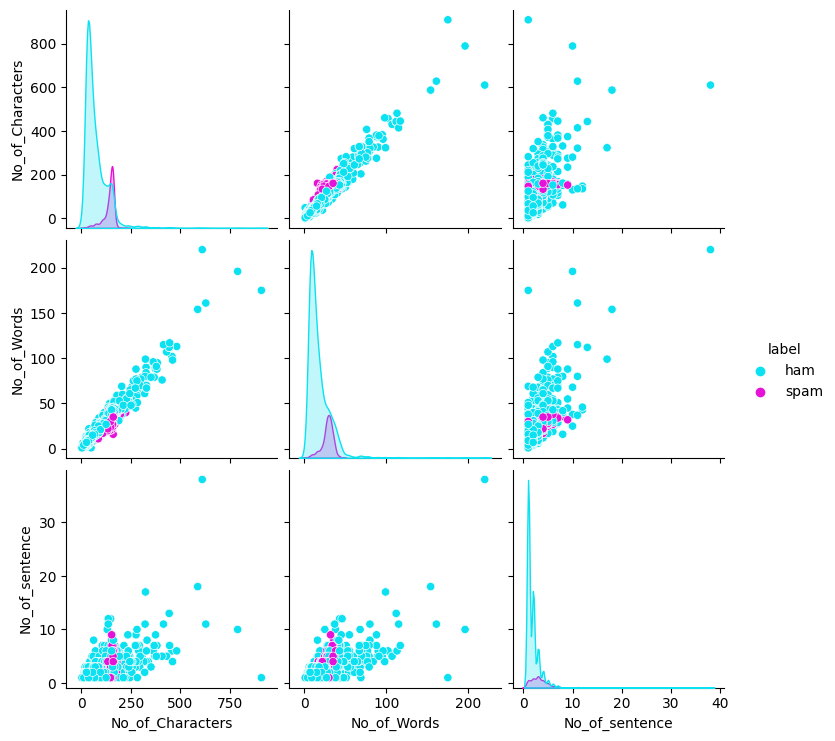

In [ ]:
plt.figure(figsize=(12,8))
fg = sns.pairplot(data=df, hue="label",palette=("#0be1f0", "#E512D8"))
plt.show(fg)

In [ ]:
 #From the pair plot, we can see a few outliers all in the class ham. This is interesting as we could put a cap over one of these.
 #Dropping the outliers. 
df = df[(df["No_of_Characters"]<350)]
df.shape

(5545, 5)

##Text Cleaning

In [ ]:
# Defining a function to clean up the text
def Clean(Text):
    sms = re.sub('[^a-zA-Z]', ' ', Text) #Replacing all non-alphabetic characters with a space
    sms = sms.lower() #converting to lowecase
    sms = sms.split()
    sms = ' '.join(sms)
    return sms

df["Clean_Text"] = df["messages"].apply(Clean)
#Lets have a look at a sample of texts after cleaning
print(" \033[1m\u001b[24;1mThe First 5 Texts after cleaning:\033[0m",*df["Clean_Text"][:5], sep = "\n")

 The First 5 Texts after cleaning:
ok lar joking wif u oni
free entry in a wkly comp to win fa cup final tkts st may text fa to to receive entry question std txt rate t c s apply over s
u dun say so early hor u c already then say
nah i don t think he goes to usf he lives around here though
freemsg hey there darling it s been week s now and no word back i d like some fun you up for it still tb ok xxx std chgs to send to rcv


<ipython-input-97-c0d17d685218>:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



##Tokenization

In [ ]:
# breaking complex data into smaller units called tokens. It can be done by splitting paragraphs into sentences and sentences into words.
df["Tokenize_Text"]=df.apply(lambda row: nltk.word_tokenize(row["Clean_Text"]), axis=1)

print("\033[1m\u001b[24;1m The First 5 Texts after Tokenizing:\033[0m",*df["Tokenize_Text"][:5], sep = "\n")

 The First 5 Texts after Tokenizing:
['ok', 'lar', 'joking', 'wif', 'u', 'oni']
['free', 'entry', 'in', 'a', 'wkly', 'comp', 'to', 'win', 'fa', 'cup', 'final', 'tkts', 'st', 'may', 'text', 'fa', 'to', 'to', 'receive', 'entry', 'question', 'std', 'txt', 'rate', 't', 'c', 's', 'apply', 'over', 's']
['u', 'dun', 'say', 'so', 'early', 'hor', 'u', 'c', 'already', 'then', 'say']
['nah', 'i', 'don', 't', 'think', 'he', 'goes', 'to', 'usf', 'he', 'lives', 'around', 'here', 'though']
['freemsg', 'hey', 'there', 'darling', 'it', 's', 'been', 'week', 's', 'now', 'and', 'no', 'word', 'back', 'i', 'd', 'like', 'some', 'fun', 'you', 'up', 'for', 'it', 'still', 'tb', 'ok', 'xxx', 'std', 'chgs', 'to', 'send', 'to', 'rcv']


<ipython-input-98-3f561447fbc0>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



##Stop Words

In [ ]:
#REMOVING STOPWORDS
#Stopwords are frequently occurring words(such as few, is, an, etc). 
#These words hold meaning in sentence structure, but do not contribute much to language processing in NLP
# Removing the stopwords function

def remove_stopwords(text):
    stop_words = set(stopwords.words("english"))
    filtered_text = [word for word in text if word not in stop_words]
    return filtered_text

df["Nostopword_Text"] = df["Tokenize_Text"].apply(remove_stopwords)

print("\033[1m\u001b[24;1m The First 5 Texts after removing the stopwords:\033[0m",*df["Nostopword_Text"][:5], sep = "\n")

 The First 5 Texts after removing the stopwords:
['ok', 'lar', 'joking', 'wif', 'u', 'oni']
['free', 'entry', 'wkly', 'comp', 'win', 'fa', 'cup', 'final', 'tkts', 'st', 'may', 'text', 'fa', 'receive', 'entry', 'question', 'std', 'txt', 'rate', 'c', 'apply']
['u', 'dun', 'say', 'early', 'hor', 'u', 'c', 'already', 'say']
['nah', 'think', 'goes', 'usf', 'lives', 'around', 'though']
['freemsg', 'hey', 'darling', 'week', 'word', 'back', 'like', 'fun', 'still', 'tb', 'ok', 'xxx', 'std', 'chgs', 'send', 'rcv']


<ipython-input-99-b3d193bc1288>:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



##Stemming and lemmatization

In [ ]:
#The stem of a word is created by removing the prefix or suffix of a word.
#lemmatization also converts a word to its root form
#lemmatization ensures that the root word belongs to the language one is dealing with

lemmatizer = WordNetLemmatizer()
# lemmatize string
def lemmatize_word(text):
    #word_tokens = word_tokenize(text)
    # provide context i.e. part-of-speech
    lemmas = [lemmatizer.lemmatize(word, pos ='v') for word in text]
    return lemmas

df["Lemmatized_Text"] = df["Nostopword_Text"].apply(lemmatize_word)
print("\033[1m\u001b[24;1m The First 5 Texts after lemitization:\033[0m",*df["Lemmatized_Text"][:5], sep = "\n")

 The First 5 Texts after lemitization:
['ok', 'lar', 'joke', 'wif', 'u', 'oni']
['free', 'entry', 'wkly', 'comp', 'win', 'fa', 'cup', 'final', 'tkts', 'st', 'may', 'text', 'fa', 'receive', 'entry', 'question', 'std', 'txt', 'rate', 'c', 'apply']
['u', 'dun', 'say', 'early', 'hor', 'u', 'c', 'already', 'say']
['nah', 'think', 'go', 'usf', 'live', 'around', 'though']
['freemsg', 'hey', 'darling', 'week', 'word', 'back', 'like', 'fun', 'still', 'tb', 'ok', 'xxx', 'std', 'chgs', 'send', 'rcv']


<ipython-input-100-89b6504d9d6a>:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



##TF-IDF

In [ ]:
#Creating a corpus of text feature to encode further into vectorized form
corpus= []
for i in df["Lemmatized_Text"]:
    msg = ' '.join([row for row in i])
    corpus.append(msg)
    
corpus[:5]
print("\033[1m\u001b[24;1m The First 5 lines in corpus :\033[0m",*corpus[:5], sep = "\n")

 The First 5 lines in corpus :
ok lar joke wif u oni
free entry wkly comp win fa cup final tkts st may text fa receive entry question std txt rate c apply
u dun say early hor u c already say
nah think go usf live around though
freemsg hey darling week word back like fun still tb ok xxx std chgs send rcv


In [ ]:
#Changing text data in to numbers. 
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(corpus).toarray()
#Let's have a look at our feature 
X.dtype


dtype('float64')

In [ ]:
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
#Label encode the Target and use it as y
label_encoder = LabelEncoder()
df["label"] = label_encoder.fit_transform(df["label"])
df.head()

<ipython-input-103-92dcc2fce934>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,label,messages,No_of_Characters,No_of_Words,No_of_sentence,Clean_Text,Tokenize_Text,Nostopword_Text,Lemmatized_Text
0,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joking wif u oni,"[ok, lar, joking, wif, u, oni]","[ok, lar, joking, wif, u, oni]","[ok, lar, joke, wif, u, oni]"
1,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entry in a wkly comp to win fa cup final ...,"[free, entry, in, a, wkly, comp, to, win, fa, ...","[free, entry, wkly, comp, win, fa, cup, final,...","[free, entry, wkly, comp, win, fa, cup, final,..."
2,0,U dun say so early hor... U c already then say...,49,13,1,u dun say so early hor u c already then say,"[u, dun, say, so, early, hor, u, c, already, t...","[u, dun, say, early, hor, u, c, already, say]","[u, dun, say, early, hor, u, c, already, say]"
3,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah i don t think he goes to usf he lives arou...,"[nah, i, don, t, think, he, goes, to, usf, he,...","[nah, think, goes, usf, lives, around, though]","[nah, think, go, usf, live, around, though]"
4,1,FreeMsg Hey there darling it's been 3 week's n...,148,39,4,freemsg hey there darling it s been week s now...,"[freemsg, hey, there, darling, it, s, been, we...","[freemsg, hey, darling, week, word, back, like...","[freemsg, hey, darling, week, word, back, like..."


##Model Building

In [ ]:
#Setting values for labels and feature as y and X(we already did X in vectorizing...)
y = df["label"] 
# Splitting the testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
#Testing on the SVC Model
#cls = SVC.fit(X_train, y_train)
sv=SVC()

clf = sv.fit(X_train, y_train)
# Dictionary of pipelines and model types for ease of reference
print(clf)

SVC()


In [ ]:
# Cossvalidation 
cv_score = cross_val_score(sv, X_train,y_train,scoring="accuracy", cv=10)
print("%s: %f " % ("SVC", cv_score.mean()))

SVC: 0.975876 


##Evaluating

In [ ]:
# Model Evaluation
# creating lists of varios scores
precision =[]
recall =[]
f1_score = []
trainset_accuracy = []
testset_accuracy = []
pred_train = clf.predict(X_train)
pred_test = clf.predict(X_test)
precision = metrics.precision_score(y_test, pred_test)
recall = metrics.recall_score(y_test, pred_test)
f1_score = metrics.f1_score(y_test, pred_test)
trainset_accuracy = clf.score(X_train,y_train)
testset_accuracy = clf.score(X_test,y_test)
  

In [ ]:
# initialise data of lists.
data = {'Precision':precision,
'Recall':recall,
'F1score':f1_score,
'Accuracy on Testset':testset_accuracy,
'Accuracy on Trainset':trainset_accuracy}
# Creates pandas DataFrame.
Results = pd.DataFrame(data, index =["SVC"])

cmap2 = ListedColormap(["#4676bd","#4676bd"])
Results.style.background_gradient(cmap=cmap2)

,Precision,Recall,F1score,Accuracy on Testset,Accuracy on Trainset
SVC,0.982609,0.818841,0.893281,0.975654,0.997520


In [ ]:
print(y_test.value_counts())

print ("-------------")

#confusion matrix
print(metrics.confusion_matrix(y_test, pred_test))


0    971
1    138
Name: label, dtype: int64
-------------
[[969   2]
 [ 25 113]]


In [ ]:
# print the first 50 true and predicted responses
print('True:', y_test.values[0:50])
print('False:', pred_test[0:50])

True: [0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 1
 0 0 0 0 0 0 0 0 0 0 0 1 0]
False: [0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1
 0 0 0 0 0 0 0 0 0 0 0 1 0]
